In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err
df = pd.read_csv('../datasets/cfb_cbball', lineterminator='\n')

print(df.shape)
df.head()

(1421, 7)


,selftext,subreddit,title,post,post_length,post_word_count,stemmed_post
0,I have seen several times during all the re-al...,1,How do research budgets impact conferences?,How do research budgets impact conferences? I ...,570,89,how do research budget impact confer ? i have ...
1,[https://www.espn.com/college-football/story/\...,1,Penn State AD says the Big Ten has more than m...,Penn State AD says the Big Ten has more than m...,889,103,penn state ad say the big ten ha more than mon...
2,247 Profile: https://247sports.com/Player/Trav...,1,2022 5* DT Travis Shaw commits to North Carolina,2022 5* DT Travis Shaw commits to North Caroli...,186,13,2022 5 * dt travi shaw commit to north carolin...
3,We are one week away from the greatest sport i...,1,One Week Away,One Week Away We are one week away from the gr...,444,76,one week away we are one week away from the gr...
4,[https://twitter.com/naevail/status/1429186980...,1,2022 3* S Nathan Vail commits to Duke,2022 3* S Nathan Vail commits to Duke [ [,266,9,2022 3 * s nathan vail commit to duke [ [


In [3]:
cfb_stop_words = ['football', 'playoff', 'field', 'gameday', 'quarterback', 'heisman']
cfb_stop_words = text.ENGLISH_STOP_WORDS.union(cfb_stop_words)

cfb_cvec = CountVectorizer(stop_words = cfb_stop_words)
cfb_sub = df['selftext'][df['subreddit'] == 1]
cfb_cvec.fit(cfb_sub)

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [4]:
bball_stop_words = ['basketball', 'tournament', 'court', 'dribble', 'shoot', 'league']
bball_stop_words = text.ENGLISH_STOP_WORDS.union(bball_stop_words)

bball_cvec = CountVectorizer(stop_words = bball_stop_words)
bball_sub = df['selftext'][df['subreddit'] == 0]
bball_cvec.fit(bball_sub)

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [5]:
stop_words = cfb_stop_words.union(bball_stop_words)

In [6]:
X = df['post']
y = df['subreddit']

y.value_counts(normalize=True)

1    0.574243
0    0.425757
Name: subreddit, dtype: float64

57% of the time the model is correct in choosing the post came from the r/CFB subreddit

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 34)

In [8]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params = {
    'tfid__stop_words': [stop_words],
    'tfid__max_features': [None, 300, 400],
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)
print('Cross val score:', gs.best_score_)
print(gs.best_params_)

Cross val score: 0.7896713615023474
{'tfid__max_features': None, 'tfid__stop_words': frozenset({'always', 'part', 'we', 'wherein', 'anywhere', 'while', 'thick', 'across', 'de', 'made', 'seem', 'into', 'in', 'yours', 'perhaps', 'three', 'seeming', 'first', 'last', 'his', 'up', 'whereby', 'show', 'somewhere', 'as', 'however', 'thence', 'before', 'may', 'bottom', 'has', 'i', 'do', 'third', 'beforehand', 'none', 'very', 'via', 'thus', 'between', 'became', 'call', 'yourself', 'myself', 'onto', 'along', 'whereafter', 'elsewhere', 'couldnt', 'could', 'itself', 'most', 'enough', 'whom', 'the', 'fill', 'through', 'sometime', 'further', 'league', 're', 'interest', 'hasnt', 'whose', 'off', 'been', 'who', 'sometimes', 'hers', 'hereupon', 'there', 'own', 'at', 'more', 'her', 'gameday', 'himself', 'forty', 'whatever', 'noone', 'fire', 'many', 'thru', 'no', 'under', 'but', 'yet', 'ever', 'same', 'were', 'playoff', 'this', 'toward', 'others', 'field', 'heisman', 'empty', 'although', 'move', 'also', 'a

In [9]:
gs.score(X_test, y_test)

0.7724719101123596

In [10]:
pred = gs.predict(X_test)
(pred != y_test).mean()

0.22752808988764045

Accuracy: 0.7724719101123596
Sensitivity: 0.9405940594059405
Precision: 0.7335907335907336
Cross val score: 0.7896713615023474


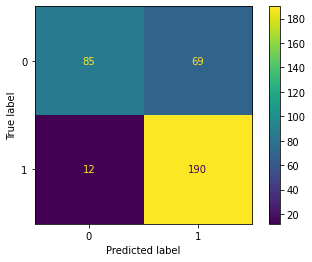

In [11]:
print('Accuracy:', gs.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, pred))
print('Precision:', metrics.precision_score(y_test, pred))
print('Cross val score:', gs.best_score_)

plot_confusion_matrix(gs, X_test, y_test);

In [12]:
pipe_2 = Pipeline([
    ('tfid', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier())
])

params_2 = {
    'rf__max_depth': [None, 5, 6, 7],
    'rf__min_samples_leaf': [1, 3, 5, 7],
    'rf__n_estimators': [75, 100, 125]
}

gs_2 = GridSearchCV(pipe_2, param_grid=params_2)
gs_2.fit(X_train, y_train)
print('Cross val score:', gs_2.best_score_)
print(gs_2.best_params_)

Cross val score: 0.7990610328638498
{'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}


In [13]:
gs_2.score(X_test, y_test)

0.7668539325842697

In [14]:
pred_2 = gs_2.predict(X_test)
(pred_2 != y_test).mean()

0.23314606741573032

Accuracy: 0.7668539325842697
Sensitivity: 0.905940594059406
Precision: 0.7408906882591093
Cross val score: 0.7990610328638498


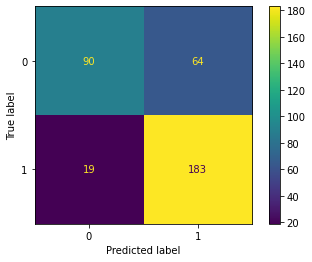

In [15]:
print('Accuracy:', gs_2.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, pred_2))
print('Precision:', metrics.precision_score(y_test, pred_2))
print('Cross val score:', (gs_2.best_score_))

plot_confusion_matrix(gs_2, X_test, y_test);